*****************************************************************
#  Research paper
- Authors: Paul Koks, Izzie He, Lisanne van Vliet, Sam Slotemaker
- TAs: Sandro Barres-Hamers, Alexander Schmatz, Márton Bodó and Danae Mitsea.
*****************************************************************

## Installing the needed packages
The following 2 cells install and import the needed packages


In [1]:
!pip install nltk
!pip install scikit-learn
!pip install seaborn

In [2]:
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

import matplotlib.pyplot as plt
import numpy as np
import csv
import os
from scipy.stats import linregress
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/samsloot/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Cleaning our data
The one codeblock below does not need to be run, but just shows the function we used to clean our comment data

In [3]:
def filter_comments(input_file, release_date):
    try:
        data = pd.read_csv(input_file)

        # check 'publishedAt' format
        data['publishedAt'] = pd.to_datetime(data['publishedAt'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
        # parse the release date
        filter_date = pd.to_datetime(release_date, format='%m/%d/%y %H:%M')
        # apply filters
        filtered_data = data[(data['isReply'] == 0) & (data['publishedAt'] < filter_date)]
        # delete two empty columns 'isReplyTo' and 'isReplyToName'
        filtered_data = filtered_data.drop(columns=['isReplyTo', 'isReplyToName'], errors='ignore')
        # Rank by 'likeCount' in descending order
        filtered_data = filtered_data.sort_values(by='likeCount', ascending=False)
        # limit to the top 100 comments
        filtered_data = filtered_data.head(100)
        # generate the output file name
        base_name, ext = os.path.splitext(input_file)
        output_file = f"{base_name}_filtered{ext}"
        # Save the filtered data to a new CSV file
        filtered_data.to_csv(output_file, index=False)

        print(f"Filtered data saved to {output_file}")
    except FileNotFoundError:
        print(f"Error: The file {input_file} was not found.")
    except KeyError as e:
        print(f"Error: The column {str(e)} is not in the CSV file.")
    except Exception as e:
        print(f"An error occurred: {e}")

## Store all comments from the CSV files with their corresponding movie ID
This cell gets all data from the comment CSVs and puts it inside a map by its movie ID, so it can later be easily extracted

In [7]:
directory = 'datasets/comments'
comments_by_movie_id = {}
# all fileNames must be [movieId].csv, where movieId is the ID from the dataset row, to make this work
files_parsed = 0
for filename in os.listdir(directory):
    if filename.endswith('.csv'): 
        filepath = os.path.join(directory, filename)
        with open(filepath, 'r') as file:
            csv_reader = csv.DictReader(file)
            data = [row for row in csv_reader]
            fileName = filename.split('.')[0];
            comments_by_movie_id[fileName] = data
            files_parsed += 1

print(f"All comments are parsed from {files_parsed} files and are stored inside the comments_by_movie_id variable!")

All comments are parsed from 40 files and are stored inside the comments_by_movie_id variable!


## Store the average sentiment of the trailer comments
This cell will analyse all comments and store their sentiment score

In [8]:
sid = SentimentIntensityAnalyzer()
sentiment_by_movie_id = {}

for movieId, comments in comments_by_movie_id.items():
    sentiment_total = 0
    likes_count = 0;
    for comment in comments:
        sentence = comment['text']
        ss = sid.polarity_scores(sentence)
        sentiment_total += ss['compound'] * int(comment['likeCount'])
        likes_count += int(comment['likeCount'])
        average_sentiment = 0;

    # some comment files are broken so added this check to not break the code
    if len(comments) != 0:
        average_sentiment = sentiment_total / (len(comments) + likes_count)
    else: 
        print('no comments found for:')
        print(movieId)
        
    sentiment_by_movie_id[movieId] = average_sentiment

print("All sentiments are analysed and stored inside the sentiment_by_movie_id variable!")

All sentiments are analysed and stored inside the sentiment_by_movie_id variable!


## Analysis
lets take the movies and strore them in movie_data, and define a some function that we can use later on to check the relation between variables 

In [9]:
with open('datasets/40MoviesDataSet.csv', 'r') as file:
    csv_reader = csv.DictReader(file)
    movie_data = [row for row in csv_reader]

def getTrailerViews(movie):
    viewCount = int(movie['viewCount'])
    return viewCount
    
def getMovieBoxOffice(movie):
    return int(movie['revenue'])

def getMovieStat(callback):
    return [callback(movie) for movie in movie_data]

def getSentimentSum(movie):
    average_sentiment = sentiment_by_movie_id[movie['id']]
    return average_sentiment * int(movie['commentCount'])  
    
def getTrailerLikes(movie):
    return int(movie['likeCount'])

def getTrailerCommentCount(movie):
    return int(movie['commentCount'])

def getMovieNames(movie):
    return movie['title']

def scatterPlot(xArray, xLabel, yArray, yLabel):    
    plt.scatter(xArray, yArray, s=10)
    
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    
    # Calculate correlation line
    slope, intercept, r_value, p_value, std_err = linregress(xArray, yArray)
    line = [slope * x + intercept for x in xArray]
    
    # Plot correlation line
    plt.plot(xArray, line, color='red', label=f"Fit line (R² = {r_value**2:.2f})")
    
    plt.show()

In [10]:
box_offices = getMovieStat(getMovieBoxOffice)
trailer_views = getMovieStat(getTrailerViews)
trailer_likes = getMovieStat(getTrailerLikes)
trailer_sentiment_sum = getMovieStat(getSentimentSum)
trailer_comment_count = getMovieStat(getTrailerCommentCount)
movie_names = getMovieStat(getMovieNames)

# x = np.column_stack((trailer_views, trailer_likes, trailer_sentiment_sum, trailer_comment_count, box_offices))
# y = np.array(box_offices)

# Create a dataframe for easier correlation analysis
data = pd.DataFrame({
    "revenue": box_offices,
    "trailerViews": trailer_views,
    "trailerLikes": trailer_likes,
    "trailerSentiment": trailer_sentiment_sum,
    "trailerComments": trailer_comment_count
})

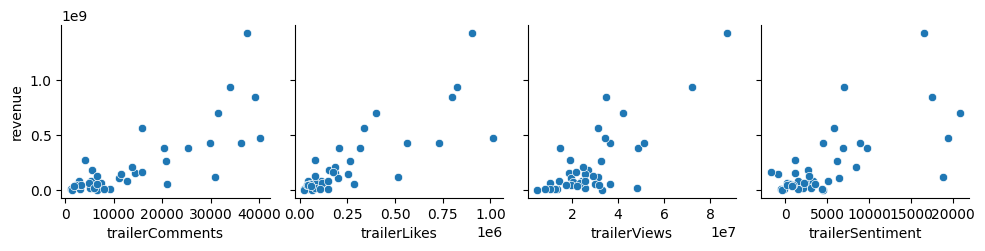

In [11]:
sns.pairplot(data, x_vars=["trailerComments", "trailerLikes", "trailerViews", "trailerSentiment"], y_vars="revenue", kind="scatter")
plt.show()

Is looks like there is indeed an upwards trend, regarding the trailer performance and the movie revenue. Lets compute a correlation matrix to see what variables seem to have the strongest correlation with the box office.

                   revenue  trailerViews  trailerLikes  trailerSentiment  \
revenue           1.000000      0.775288      0.822540          0.677282   
trailerViews      0.775288      1.000000      0.691832          0.489132   
trailerLikes      0.822540      0.691832      1.000000          0.753629   
trailerSentiment  0.677282      0.489132      0.753629          1.000000   
trailerComments   0.788255      0.615883      0.932100          0.812767   

                  trailerComments  
revenue                  0.788255  
trailerViews             0.615883  
trailerLikes             0.932100  
trailerSentiment         0.812767  
trailerComments          1.000000  


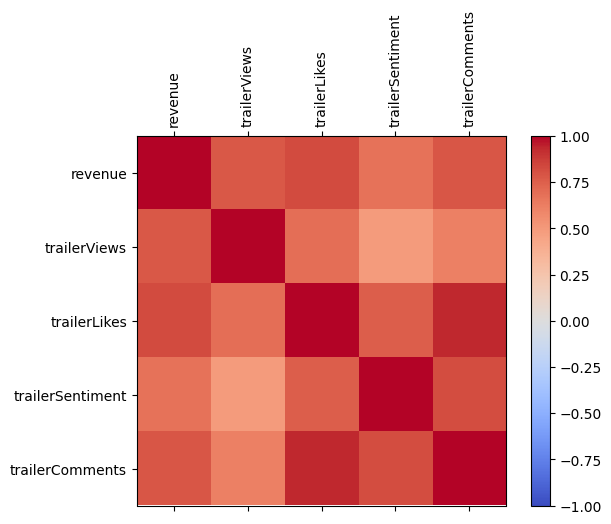

In [12]:
correlation_matrix = data.corr()
print(correlation_matrix)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlation_matrix,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
plt.show()

## Box office correlation
We are most interested in a correlation between variables and the box office, it looks like the strongest correlation is between box office and the amount of likes the trailer gets, lets plot this relation a bit larger:

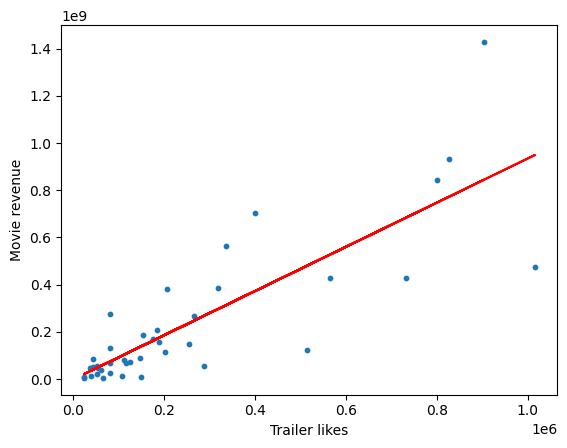

In [13]:
scatterPlot(trailer_likes, "Trailer likes", box_offices, "Movie revenue")

Now lets create a linear regression modal from our data:

In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

X = data[["trailerComments", "trailerLikes", "trailerViews", "trailerSentiment"]]
pca = PCA(n_components=1)
data["engagement"] = pca.fit_transform(X)

x = data[["engagement"]] 
y = data["revenue"]

# Linear Regression
model = LinearRegression()
model.fit(x, y)

# Coefficients
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

# R-squared
r_squared = model.score(x, y)
print("R-squared:", r_squared)

Coefficients: [14.51807626]
Intercept: 230584651.92499998
R-squared: 0.6011542511832659


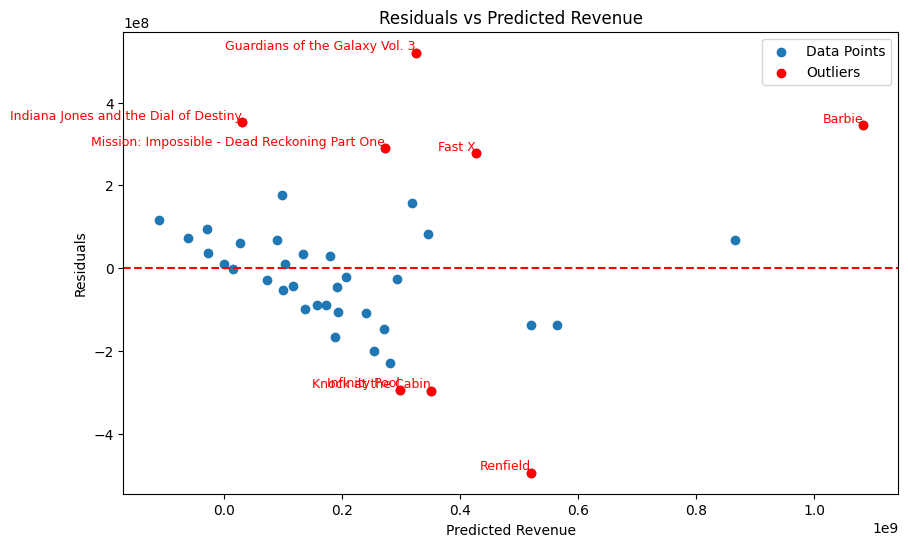

In [48]:
import matplotlib.pyplot as plt

predictions = model.predict(x)
residuals = y - predictions

# Calculate threshold for outliers
mean_residual = np.mean(residuals)
std_residual = np.std(residuals)
threshold = 1.3 * std_residual

# Identify outliers
outliers = np.abs(residuals) > threshold

lower_outliers_moive_titles = []
higher_outliers_moive_titles = []

plt.figure(figsize=(10, 6))
plt.scatter(predictions, residuals, label="Data Points")


# Add labels for outliers only
for i, (pred, resid, is_outlier) in enumerate(zip(predictions, residuals, outliers)):
    if is_outlier:
        plt.text(pred, resid, movie_names[i], fontsize=9, ha="right", va="bottom", color="red")
        # add outliers to lists to show them lateron
        if resid < threshold:
            lower_outliers_moive_titles.append(movie_names[i])
        else:
            higher_outliers_moive_titles.append(movie_names[i])

# Highlight outliers
plt.scatter(predictions[outliers], residuals[outliers], color="red", label="Outliers")

plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Revenue")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Revenue")
plt.legend()
plt.show()



In [49]:
filtered_movies_higher = [movie for movie in movie_data if movie["title"] in higher_outliers_moive_titles]
filtered_movies_lower = [movie for movie in movie_data if movie["title"] in lower_outliers_moive_titles]

def printMovieData(movies):
    for movie in movies:
        print(f'{movie["title"]}: {movie["budget"]}')
    print()
    

print('Higher: ')
printMovieData(filtered_movies_higher)

print('Lower: ')
printMovieData(filtered_movies_lower)


Higher: 
Barbie: 145000000
Mission: Impossible - Dead Reckoning Part One: 291000000
Indiana Jones and the Dial of Destiny: 294700000
Fast X: 340000000
Guardians of the Galaxy Vol. 3: 250000000

Lower: 
Renfield: 65000000
Knock at the Cabin: 20000000
Infinity Pool: 4500000

